In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

from numpy import genfromtxt


import pandas as pd

from mpl_toolkits import mplot3d
#%matplotlib notebook

import math

#import cv2
import pims
from PIL import Image

import skimage

import json

#own modules / functions
import sys

sys.path.append("./modules")
import TiffProcessing as tiffproc
import InputProcessing as inproc
sys.path.append("./classes")
import Track

# input data

In [2]:
inputParameters = pd.read_csv('../_inputParameters.csv',names=['key','value'])


inputDataFolder = inproc.getInputParameter(inputParameters,"inputDataFolder")
outputDataFolder = inproc.getInputParameter(inputParameters,"outputDataFolder")

trackingCsvFilename = inproc.getInputParameter(inputParameters,"trackingCsvFilename")
trackingCsvFilenameProcessed = inproc.getInputParameter(inputParameters,"trackingCsvFilenameProcessed")

slave_outputDataFolder  = inproc.getInputParameter(inputParameters,"slave_outputDataFolder")
master_outputDataFolder  = inproc.getInputParameter(inputParameters,"master_outputDataFolder")

slave_uniqueFilenameString = inproc.getInputParameter(inputParameters,"slave_uniqueFilenameString")
master_uniqueFilenameString = inproc.getInputParameter(inputParameters,"master_uniqueFilenameString")


slave_trackingProcessedBildFilename = inproc.getInputParameter(inputParameters,"slave_trackingProcessedBildFilename")
master_trackingProcessedBildFilename = inproc.getInputParameter(inputParameters,"master_trackingProcessedBildFilename")



framerate_msec = float(inproc.getInputParameter(inputParameters,"framerate_msec"))
movieLength = int(inproc.getInputParameter(inputParameters,"movieLength"))





In [3]:
slave_filesOfInterest = inproc.getFilenamesOfInputTiffFiles(inputDataFolder,slave_uniqueFilenameString)
master_filesOfInterest = inproc.getFilenamesOfInputTiffFiles(inputDataFolder,master_uniqueFilenameString)

--- folder searched in: /Users/johannesschoeneberg/git/LatticeTrack/data/test_input/crop_100x100x100_bleachCorrected/
--- example of files found: cropped_488_pm50px_maxAmpl_0000.tif_ratioCorrected.tif
--- number of files found: 70
--- folder searched in: /Users/johannesschoeneberg/git/LatticeTrack/data/test_input/crop_100x100x100_bleachCorrected/
--- example of files found: cropped_560_pm50px_maxAmpl_0000.tif_ratioCorrected.tif
--- number of files found: 70


/Users/johannesschoeneberg/git/LatticeTrack/data/test_input/crop_100x100x100_bleachCorrected//cropped_560_pm50px_maxAmpl_0000.tif_ratioCorrected.tif
(100, 100, 100)


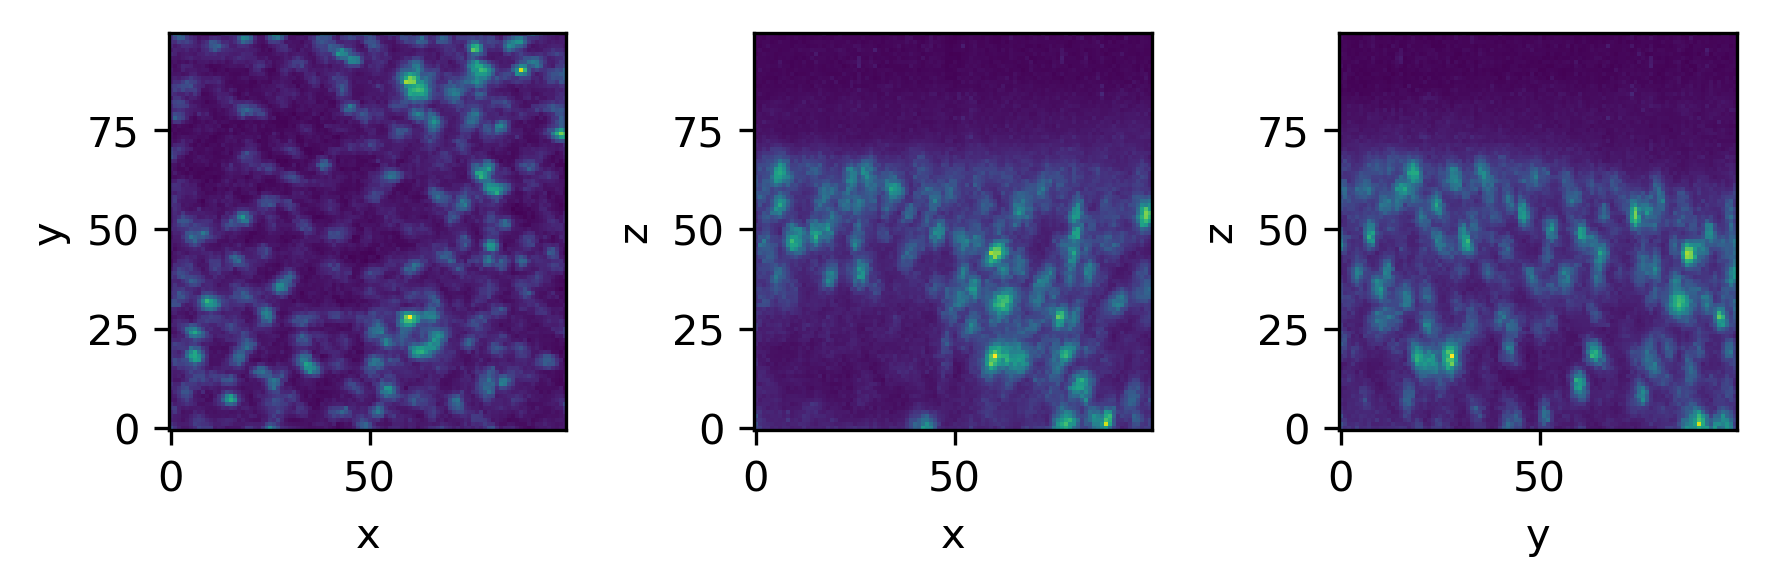

In [4]:
# read the image from where the detections come from
frameId = 0

path = inputDataFolder+'/'+master_filesOfInterest[frameId]
print(path)
latticeMovieFrame = skimage.external.tifffile.imread(path)
latticeMovieFrame_shape = latticeMovieFrame.shape
print(latticeMovieFrame_shape)

tiffproc.maxIntensityProjection(latticeMovieFrame)

In [5]:
# read the raw csv data for further processing

path = outputDataFolder+'/'+trackingCsvFilenameProcessed
print(path)

data = pd.read_csv(path,header=0)
data.columns = ["trackId","tracklength","time[s]","frameId","lifetime","catIdx","m_x",'m_y',"m_z","m_A","m_c","m_pval_Ar","s_x",'s_y',"s_z","s_A","s_c","s_pval_Ar"]
trackIds = data.drop_duplicates(subset='trackId')['trackId'].values

data[0:5]






/Users/johannesschoeneberg/git/LatticeTrack/data/test_input/crop_100x100x100_bleachCorrected/output/trackedFeaturesProcessed.csv


,trackId,tracklength,time[s],frameId,lifetime,catIdx,m_x,m_y,m_z,m_A,m_c,m_pval_Ar,s_x,s_y,s_z,s_A,s_c,s_pval_Ar
0,1,83,0,1,398.23,8,7.904661e+01,6.464731e+01,8.131298e+01,2.380362e+04,5.097926e+03,0,7.861783e+01,6.335770e+01,8.131298e+01,1.455107e+04,1.618403e+04,9.994436e-01
1,1,83,5.689000e+00,2,398.23,8,7.850739e+01,6.542015e+01,8.129176e+01,2.104784e+04,5.305183e+03,0,7.755419e+01,6.464906e+01,8.129176e+01,1.635423e+04,1.955088e+04,7.208670e-21
2,1,83,1.137800e+01,3,398.23,8,7.839408e+01,6.518394e+01,8.116666e+01,2.085433e+04,5.234626e+03,0,7.735373e+01,6.428964e+01,8.116666e+01,7.358672e+03,1.554692e+04,1
3,1,83,1.706700e+01,4,398.23,8,7.802180e+01,6.560145e+01,8.168228e+01,2.318226e+04,6.263921e+03,0,7.704685e+01,6.395467e+01,8.168228e+01,9.978225e+03,1.407360e+04,1
4,1,83,2.275600e+01,5,398.23,8,7.721728e+01,6.629176e+01,8.136034e+01,2.259943e+04,5.388422e+03,0,7.959930e+01,6.657997e+01,8.136034e+01,1.417622e+04,1.468696e+04,3.412941e-172


# select subset

In [7]:
# select a subset of the tracks, e.g. for displaying only long tracks

trackIdsLong = (data[data['tracklength'] > 10]).drop_duplicates(subset='trackId')['trackId'].values
allTrackIds = np.unique(data['trackId'].values)
cat_Ia_Tracks = np.unique(data[data['catIdx'] == 1]['trackId'])
cat_Ib_Tracks = np.unique(data[data['catIdx'] == 2]['trackId'])
cat_Ic_Tracks = np.unique(data[data['catIdx'] == 3]['trackId'])
cat_Id_Tracks = np.unique(data[data['catIdx'] == 4]['trackId'])
cat_IIa_Tracks = np.unique(data[data['catIdx'] == 5]['trackId'])
cat_IIb_Tracks = np.unique(data[data['catIdx'] == 6]['trackId'])
cat_IIc_Tracks = np.unique(data[data['catIdx'] == 7]['trackId'])
cat_IId_Tracks = np.unique(data[data['catIdx'] == 8]['trackId'])


print('len(trackIdsLong)/len(allTrackIds)')
print(str(len(trackIdsLong))+'/'+str(len(allTrackIds)))
print()
print(trackIdsLong)
print('/')
print(allTrackIds)

len(trackIdsLong)/len(allTrackIds)
630/1555

[  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126
 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144
 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162
 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180
 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198
 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216
 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234
 235 2

Text(0,0.5,'amplitude')

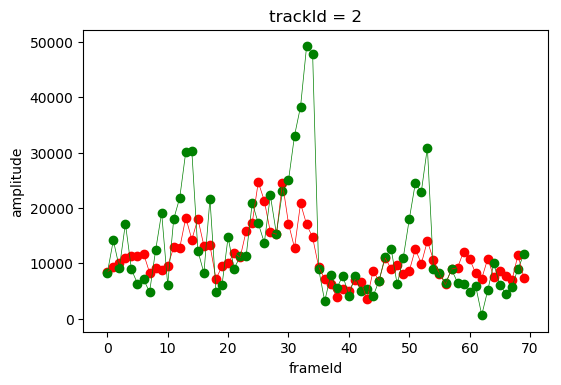

In [10]:
trackSelectionId = 1
trackSelection = allTrackIds

trackId = trackSelection[trackSelectionId]
track = data[data['trackId'] == trackId]
plt.figure(dpi=100)
ax = plt.axes()

# Data for a three-dimensional line
m_x = track['m_x'].values.astype(float)
m_y = track['m_y'].values.astype(float)
m_z = track['m_z'].values.astype(float)
m_intensity = track['m_A'].values.astype(float)

s_x = track['s_x'].values.astype(float)
s_y = track['s_y'].values.astype(float)
s_z = track['s_z'].values.astype(float)
s_intensity = track['s_A'].values.astype(float)

# Data for three-dimensional scattered points
#zdata = 15 * np.random.random(100)
#xdata = np.sin(zdata) + 0.1 * np.random.randn(100)
#ydata = np.cos(zdata) + 0.1 * np.random.randn(100)
#ax.scatter(x, y, z, alpha=0.8, c=color, edgecolors='none', s=30, label=group)
#if(color=='intensity'):
#    ax.scatter3D(x, y, z, c=intensity, cmap='cool',s=100);
#else:
ax.plot(m_intensity,c='red',lw=0.5)
ax.scatter(range(0,len(m_intensity)),m_intensity,c='red')
ax.plot(s_intensity,c='green',lw=0.5)
ax.scatter(range(0,len(s_intensity)),s_intensity,c='green')
plt.title('trackId = '+str(trackId))
plt.xlabel('frameId')
plt.ylabel('amplitude')



Text(0.5,0.8464,'master(red) slave(green)')

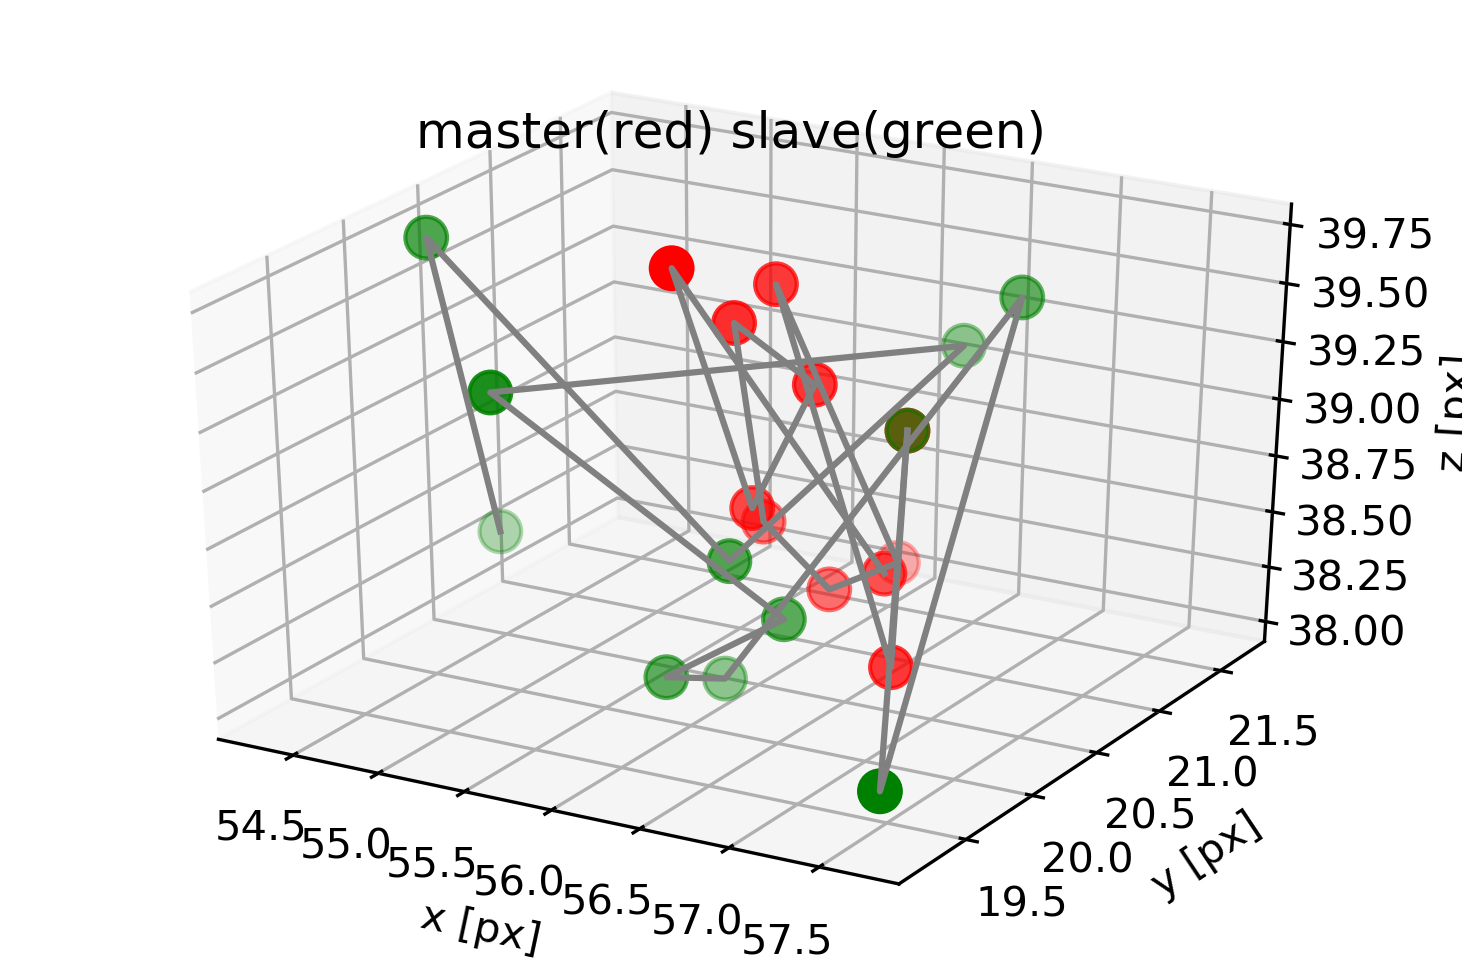

In [156]:
track = data[data['trackId'] == trackId]
plt.figure(dpi=300)
ax = plt.axes(projection='3d')

# Data for a three-dimensional line
m_x = track['m_x'].values.astype(float)
m_y = track['m_y'].values.astype(float)
m_z = track['m_z'].values.astype(float)
m_intensity = track['m_A'].values.astype(float)
ax.plot3D(m_x, m_y, m_z, 'grey')

# Data for three-dimensional scattered points
#zdata = 15 * np.random.random(100)
#xdata = np.sin(zdata) + 0.1 * np.random.randn(100)
#ydata = np.cos(zdata) + 0.1 * np.random.randn(100)
#ax.scatter(x, y, z, alpha=0.8, c=color, edgecolors='none', s=30, label=group)
#if(color=='intensity'):
#    ax.scatter3D(x, y, z, c=intensity, cmap='cool',s=100);
#else:
ax.scatter3D(m_x, m_y, m_z,c='red',s=100);
plt.xlabel('x [px]')
plt.ylabel('y [px]')
ax.set_zlabel('z [px]')
ax.set_title('master')

# Data for a three-dimensional line
s_x = track['s_x'].values.astype(float)
s_y = track['s_y'].values.astype(float)
s_z = track['s_z'].values.astype(float)
s_intensity = track['s_A'].values.astype(float)
ax.plot3D(s_x, s_y, s_z, 'grey')

# Data for three-dimensional scattered points
#zdata = 15 * np.random.random(100)
#xdata = np.sin(zdata) + 0.1 * np.random.randn(100)
#ydata = np.cos(zdata) + 0.1 * np.random.randn(100)
#ax.scatter(x, y, z, alpha=0.8, c=color, edgecolors='none', s=30, label=group)
#if(color=='intensity'):
#    ax.scatter3D(x, y, z, c=intensity, cmap='cool',s=100);
#else:
ax.scatter3D(s_x, s_y, s_z,c='green',s=100);
plt.xlabel('x [px]')
plt.ylabel('y [px]')
ax.set_zlabel('z [px]')
ax.set_title('master(red) slave(green)')

Text(0.5,0.92,'master')

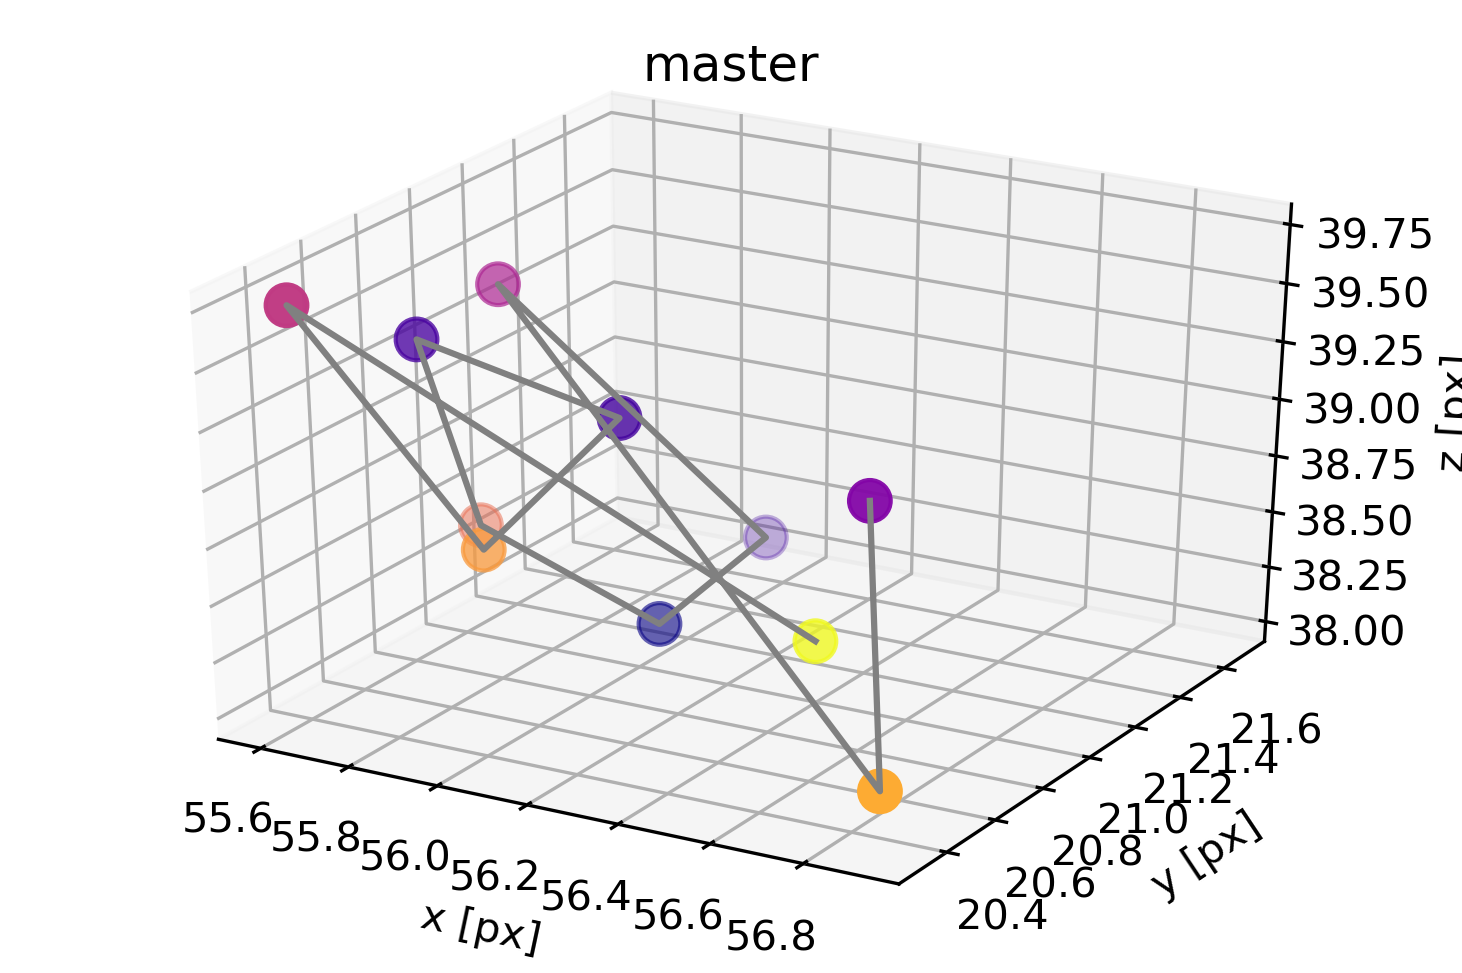

In [157]:
track = data[data['trackId'] == trackId]
plt.figure(dpi=300)
ax = plt.axes(projection='3d')

# Data for a three-dimensional line
m_x = track['m_x'].values.astype(float)
m_y = track['m_y'].values.astype(float)
m_z = track['m_z'].values.astype(float)
m_intensity = track['m_A'].values.astype(float)
ax.plot3D(m_x, m_y, m_z, 'grey')

# Data for three-dimensional scattered points
#zdata = 15 * np.random.random(100)
#xdata = np.sin(zdata) + 0.1 * np.random.randn(100)
#ydata = np.cos(zdata) + 0.1 * np.random.randn(100)
#ax.scatter(x, y, z, alpha=0.8, c=color, edgecolors='none', s=30, label=group)
#if(color=='intensity'):
#    ax.scatter3D(x, y, z, c=intensity, cmap='cool',s=100);
#else:
ax.scatter3D(m_x, m_y, m_z,c=m_intensity, cmap='plasma',s=100);
plt.xlabel('x [px]')
plt.ylabel('y [px]')
ax.set_zlabel('z [px]')
ax.set_title('master')

Text(0.5,0.92,'slave')

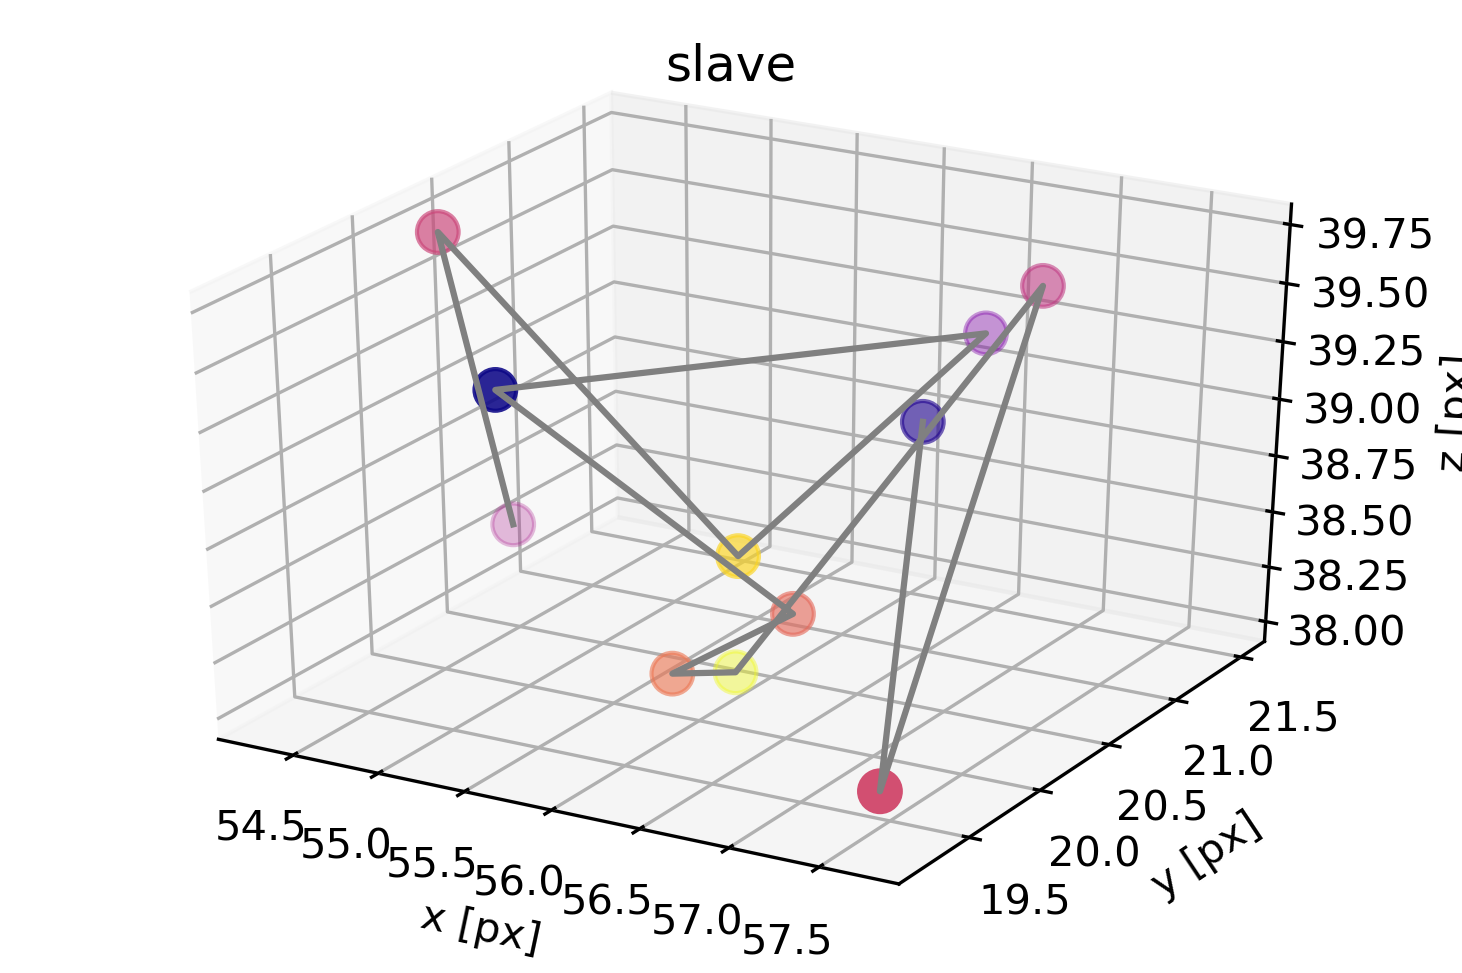

In [158]:
track = data[data['trackId'] == trackId]
plt.figure(dpi=300)
ax = plt.axes(projection='3d')

# Data for a three-dimensional line
s_x = track['s_x'].values.astype(float)
s_y = track['s_y'].values.astype(float)
s_z = track['s_z'].values.astype(float)
s_intensity = track['s_A'].values.astype(float)
ax.plot3D(s_x, s_y, s_z, 'grey')

# Data for three-dimensional scattered points
#zdata = 15 * np.random.random(100)
#xdata = np.sin(zdata) + 0.1 * np.random.randn(100)
#ydata = np.cos(zdata) + 0.1 * np.random.randn(100)
#ax.scatter(x, y, z, alpha=0.8, c=color, edgecolors='none', s=30, label=group)
#if(color=='intensity'):
#    ax.scatter3D(x, y, z, c=intensity, cmap='cool',s=100);
#else:
ax.scatter3D(s_x, s_y, s_z,c=s_intensity, cmap='plasma',s=100);
plt.xlabel('x [px]')
plt.ylabel('y [px]')
ax.set_zlabel('z [px]')
ax.set_title('slave')

Text(0.5,0.92,'master')

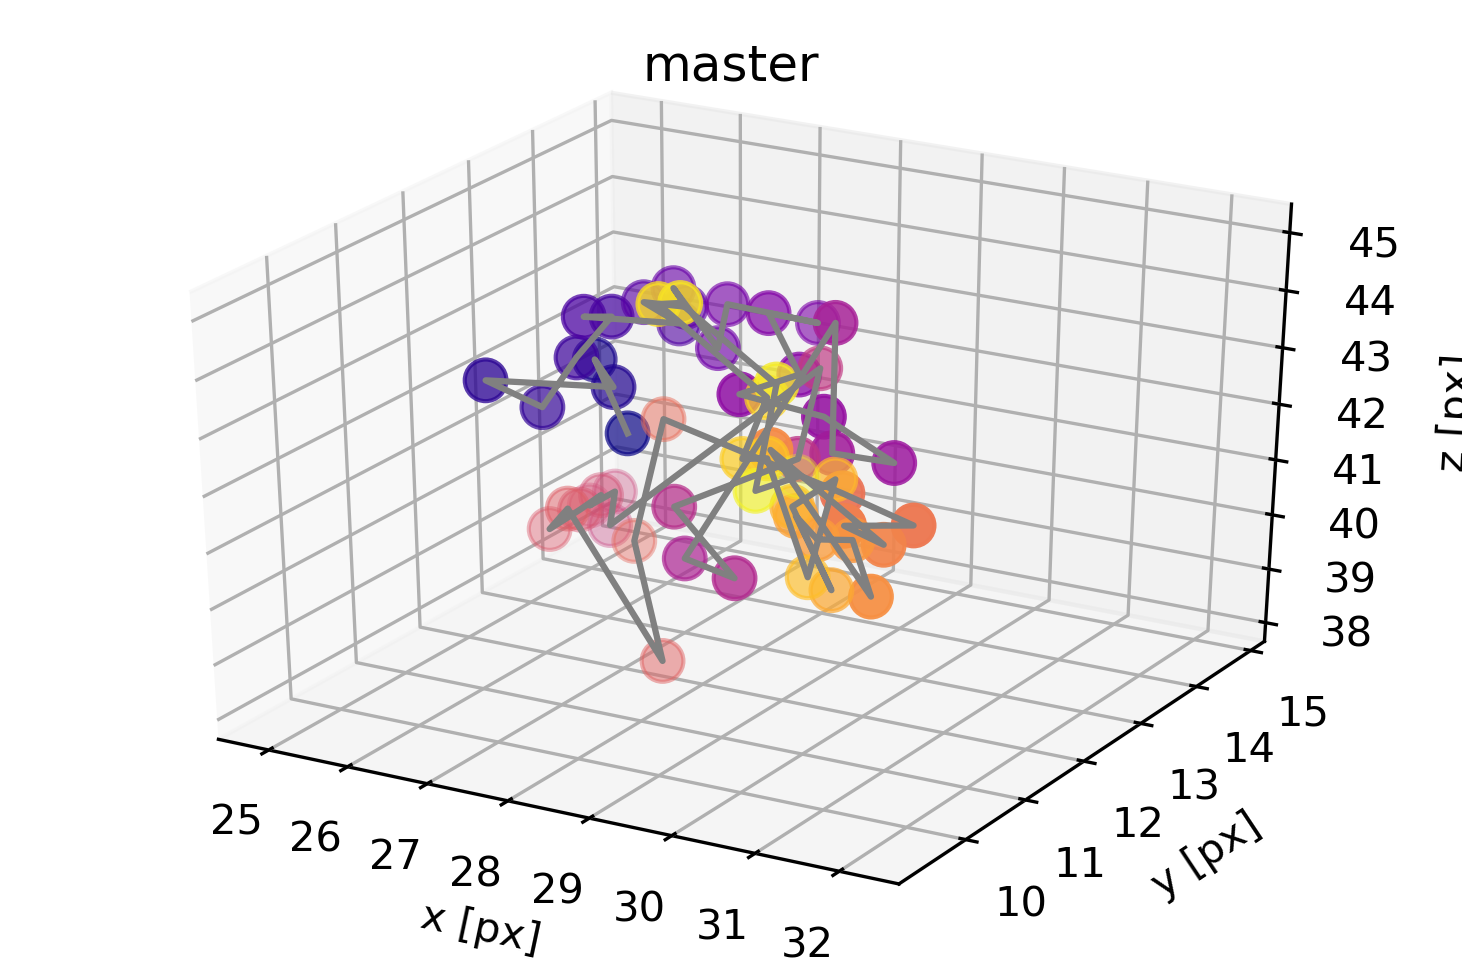

In [144]:
track = data[data['trackId'] == trackId]
plt.figure(dpi=300)
ax = plt.axes(projection='3d')

# Data for a three-dimensional line
m_x = track['m_x'].values.astype(float)
m_y = track['m_y'].values.astype(float)
m_z = track['m_z'].values.astype(float)
frameId = track['frameId'].values.astype(int)
m_intensity = track['m_A'].values.astype(float)
ax.plot3D(m_x, m_y, m_z, 'grey')

# Data for three-dimensional scattered points
#zdata = 15 * np.random.random(100)
#xdata = np.sin(zdata) + 0.1 * np.random.randn(100)
#ydata = np.cos(zdata) + 0.1 * np.random.randn(100)
#ax.scatter(x, y, z, alpha=0.8, c=color, edgecolors='none', s=30, label=group)
#if(color=='intensity'):
#    ax.scatter3D(x, y, z, c=intensity, cmap='cool',s=100);
#else:
ax.scatter3D(m_x, m_y, m_z,c=frameId, cmap='plasma',s=100);
plt.xlabel('x [px]')
plt.ylabel('y [px]')
ax.set_zlabel('z [px]')
ax.set_title('master')

Text(0.5,0.92,'slave')

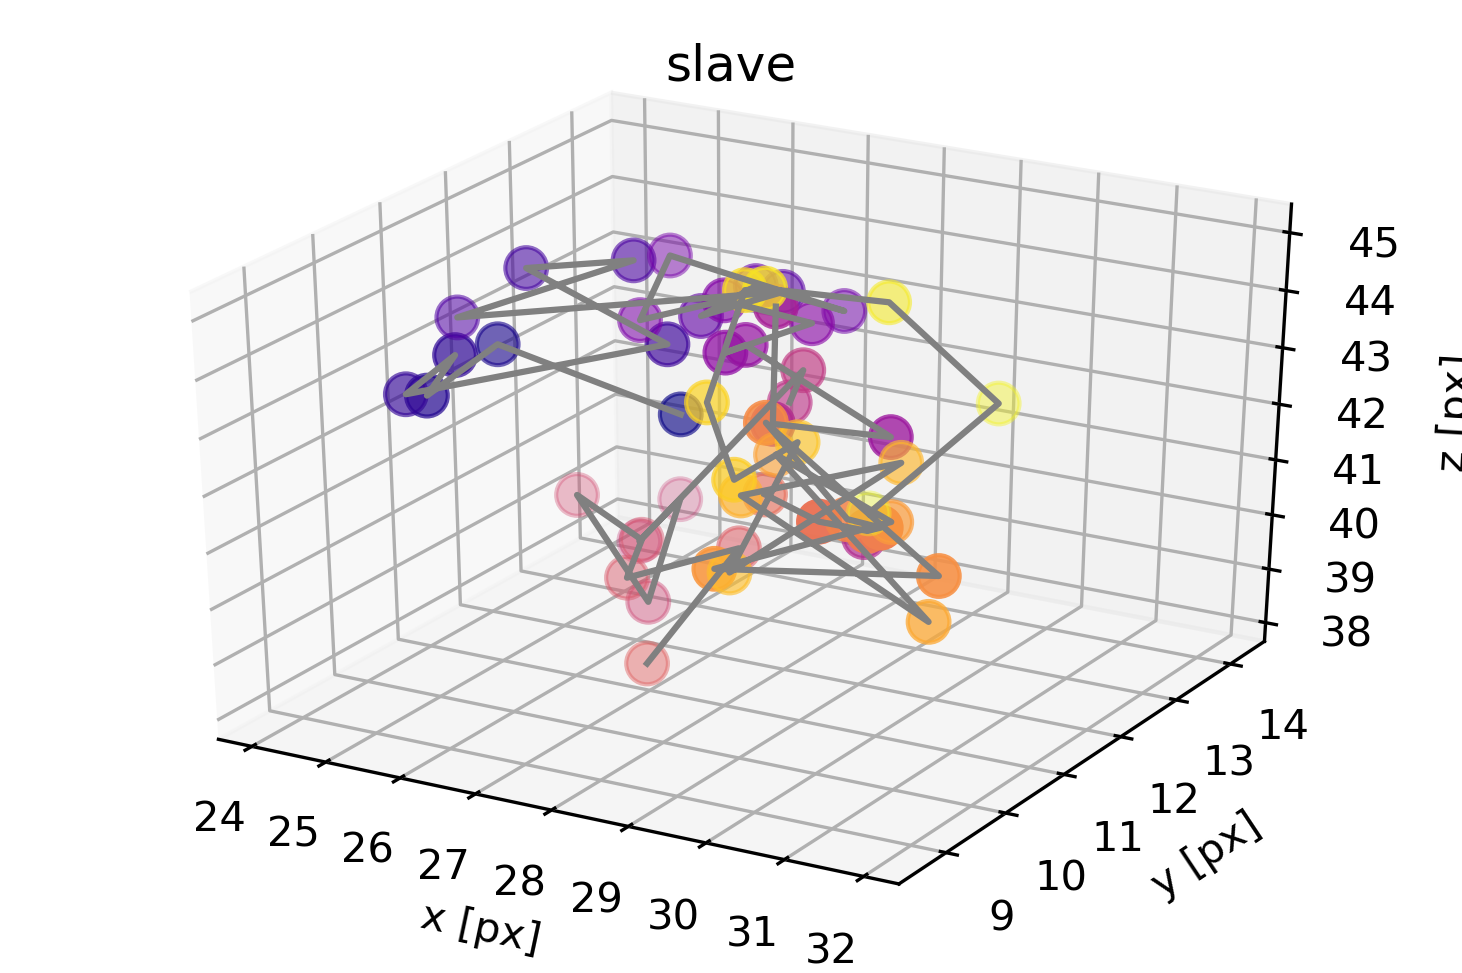

In [145]:
track = data[data['trackId'] == trackId]
plt.figure(dpi=300)
ax = plt.axes(projection='3d')

# Data for a three-dimensional line
s_x = track['s_x'].values.astype(float)
s_y = track['s_y'].values.astype(float)
s_z = track['s_z'].values.astype(float)
frameId = track['frameId'].values.astype(int)
s_intensity = track['s_A'].values.astype(float)
ax.plot3D(s_x, s_y, s_z, 'grey')

# Data for three-dimensional scattered points
#zdata = 15 * np.random.random(100)
#xdata = np.sin(zdata) + 0.1 * np.random.randn(100)
#ydata = np.cos(zdata) + 0.1 * np.random.randn(100)
#ax.scatter(x, y, z, alpha=0.8, c=color, edgecolors='none', s=30, label=group)
#if(color=='intensity'):
#    ax.scatter3D(x, y, z, c=intensity, cmap='cool',s=100);
#else:
ax.scatter3D(s_x, s_y, s_z,c=frameId, cmap='plasma',s=100);
plt.xlabel('x [px]')
plt.ylabel('y [px]')
ax.set_zlabel('z [px]')
ax.set_title('slave')